In [1]:
import pandas as pd
import numpy as np
import ast
import joblib
from pprint import pprint
from time import time
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline

tweets = pd.read_csv('../tweets/tweets_clean.csv', header=0)
print(tweets.isna().sum())
tweets.dropna(subset=['lemmas'], inplace=True)
tweets.reset_index(drop=True, inplace=True)

tweet_docs = tweets.lemmas.tolist()
tweet_orig = tweets.text.tolist()

pipeline = Pipeline([('vect', CountVectorizer(max_df=0.95,
                                              min_df=100)),
                     ('lda', LatentDirichletAllocation(max_iter=10,
                                                       learning_method='online'))])
params = {'lda__learning_decay': (0.5, 0.7, 0.9),
          'lda__n_components': (2, 5, 10, 15, 20, 25, 30, 35),
          # 'vect__max_features': (None, 50000, 100000),
          # 'vect__max_df': (0.5, 0.75, 0.95),
          # 'vect__min_df': (0, 10, 100)
          }

user_key         0
date             0
text             0
tweet_id      2314
hashtags         0
mentions         0
clean_text     378
lemmas         893
dtype: int64


In [ ]:
if __name__ == '__main__':
    grid_search = GridSearchCV(pipeline, params,
                               cv=5, n_jobs=-1, verbose=2)
    print('Performing grid search')
    print('Pipeline:', [name for name, _ in pipeline.steps])
    print('Parameters:')
    pprint(params)
    t0 = time()
    print('Start time: {}'.format(t0))
    grid_search.fit(tweet_docs)
    print('Completed in {:.3f}s'.format(time() - t0))
    print()

    print('Best Log Likelihood: {:.3f}'.format(grid_search.best_score_))
    print('Best Parameters set:')
    best_params = grid_search.best_params_
    for k, v in best_params.items():
        print('{}: {}'.format(k, v))

    results = grid_search.cv_results_
    pd.DataFrame(results).to_csv('./topic_modeling_objects/cv_results_df.csv', index=False)

In [2]:
plt.style.use('seaborn-whitegrid')

results = pd.read_csv('../scripts/topic_modeling_objects/cv_results_df.csv', header=0)
results['params'] = results.params.apply(ast.literal_eval)

num_topics = [2, 5, 10, 15, 20, 25, 30, 35]
scores_5 = results.loc[results['param_lda__learning_decay'] == 0.5, 'mean_test_score']
std_5 = results.loc[results['param_lda__learning_decay'] == 0.5, 'std_test_score']
scores_7 = results.loc[results['param_lda__learning_decay'] == 0.7, 'mean_test_score']
std_7 = results.loc[results['param_lda__learning_decay'] == 0.7, 'std_test_score']
scores_9 = results.loc[results['param_lda__learning_decay'] == 0.9, 'mean_test_score']
std_9 = results.loc[results['param_lda__learning_decay'] == 0.9, 'std_test_score']

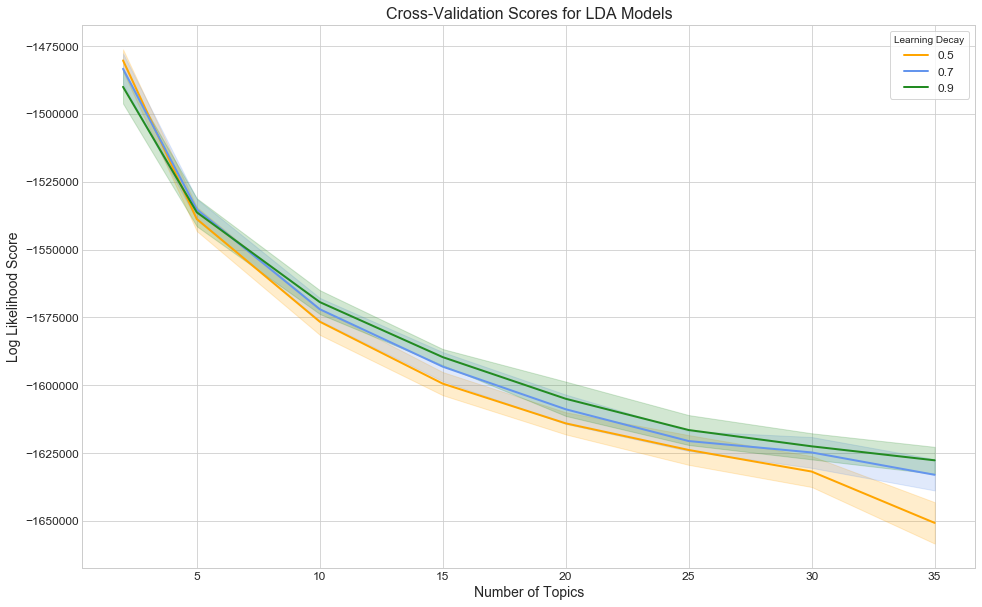

In [3]:
fig = plt.figure(figsize=(16, 10))

plt.plot(num_topics, scores_5,
         color='orange', label='0.5', linewidth=2)
plt.fill_between(num_topics,
                 (np.array(scores_5) - np.array(std_5)), (np.array(scores_5) + np.array(std_5)),
                 color='orange', alpha=0.2)
plt.plot(num_topics, scores_7,
         color='cornflowerblue', label='0.7', linewidth=2)
plt.fill_between(num_topics,
                 (np.array(scores_7) - np.array(std_7)), (np.array(scores_7) + np.array(std_7)),
                 color='cornflowerblue', alpha=0.2)
plt.plot(num_topics, scores_9,
         color='forestgreen', label='0.9', linewidth=2)
plt.fill_between(num_topics,
                 (np.array(scores_9) - np.array(std_9)), (np.array(scores_9) + np.array(std_9)),
                 color='forestgreen', alpha=0.2)

plt.xlabel('Number of Topics', fontsize=14)
plt.ylabel('Log Likelihood Score', fontsize=14)
plt.title('Cross-Validation Scores for LDA Models', fontsize=16)
plt.legend(title='Learning Decay', loc='best', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12)

fig.savefig('../visuals/cv_scores.png')

plt.show()

In [4]:
# Fit chosen model and save model object
cv = CountVectorizer(max_df=0.95,
                     min_df=100)
tf = cv.fit_transform(tweet_docs)
tf_names = cv.get_feature_names()

lda = LatentDirichletAllocation(n_components=15,
                                max_iter=10,
                                learning_method='online',
                                learning_decay=0.7,
                                random_state=123)
lda_model = lda.fit(tf)

print('Perplexity: {:.3f}'.format(lda_model.perplexity(tf)))
print('Log likelihood: {:.3f}'.format(lda_model.score(tf)))

# Save vectorizer
with open('../scripts/topic_modeling_objects/sklearn_vect.joblib', 'wb') as f_out:
    joblib.dump(cv, f_out)

# Save term frequency matrix
with open('../scripts/topic_modeling_objects/sklearn_CV.joblib', 'wb') as f_out:
    joblib.dump(tf, f_out)

# Save feature names
with open('../scripts/topic_modeling_objects/sklearn_feature_names.joblib', 'wb') as f_out:
    joblib.dump(tf_names, f_out)

# Save fitted model
with open('../scripts/topic_modeling_objects/sklearn_LDA_model.joblib', 'wb') as f_out:
    joblib.dump(lda_model, f_out)

Perplexity: 2026.343
Log likelihood: -7959944.694
